<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyRegressor


## Подготовка

In [2]:
# функция для подгрузки датасета
path_1 = '/datasets/taxi.csv'
path_2 = "C:\\DS\\YP\\S15\\taxi.csv"


def generate_data (path_1, path_2):
    if os.path.exists(path_1):
        df = pd.read_csv(path_1)
    elif os.path.exists(path_2):
        df = pd.read_csv(path_2)
    else:
        print('Something is wrong')
    return df

In [3]:
# загружаем датасет
df = generate_data(path_1, path_2)

# проверка
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Выведем информацию о датасете

In [4]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Описание данных:**

datetime  дата и время интервалом в 10 минут 

num_orders - количество заказов такси в 10-ти минутный интервал

Проверим отсортирован ли столбец с датами

In [5]:
print(df.index.is_monotonic_increasing)

True


Столбец, отсортирован, всё в порядке

Найдём минимальное и максимальное значение дат

In [6]:
# находим минимальное значение
df['datetime'].min()

'2018-03-01 00:00:00'

In [7]:
# находим максимальное значение
df['datetime'].max()

'2018-08-31 23:50:00'

У нас есть данные с 1го марта 2018 года по 31е августа 2018 года

Изменим тип данных столбца datetime с типа 'object' на тип 'datetime'

In [8]:
# замена типа данных
df['datetime'] = df['datetime'].astype('datetime64[ns]')

# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Проверим данные на пропуски

In [9]:
# проверка на пропуски
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Проверим на дубликаты

In [10]:
# проверка на дубликаты
df.duplicated().sum()

0

Для удобства установим столбец datetime как индекс

In [11]:
# устанавливаем столбец 'datetime' как индекс
df = df.set_index('datetime')

# проверка
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведём ресемплирование даннх по одному часу

In [12]:
# делаем ресемлирование по одному часу
df = df.resample('1H').sum()

# проверка
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Построим гистрограмму заказов для демонстрации распредления

<Figure size 1008x576 with 0 Axes>

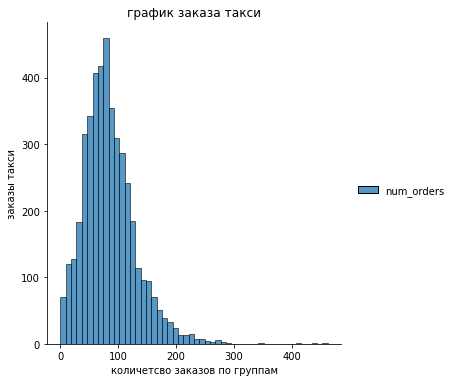

In [13]:
plt.figure(figsize=(14, 8))

ax = sns.displot(
    data=df,
    kde=False,
    bins=50
)

ax.set(
    xlabel='количетсво заказов по группам',
    ylabel='заказы такси',
    title='график заказа такси'
);   



Построим boxplot для проверки на выборосы

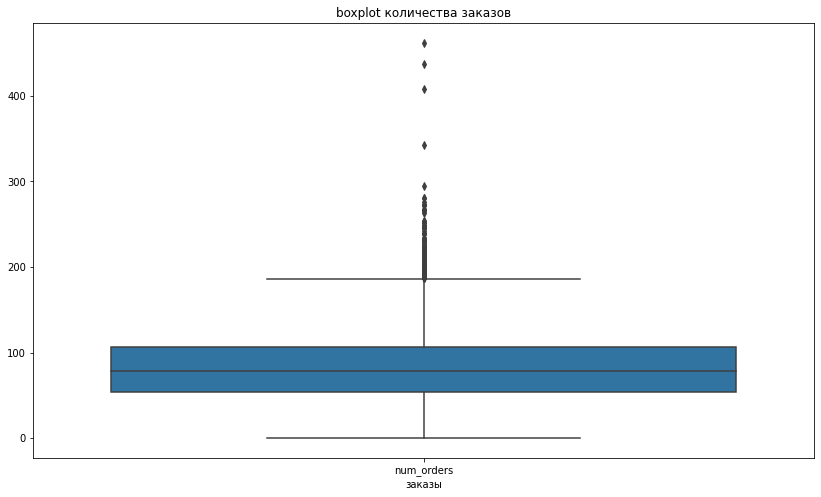

In [14]:
plt.figure(figsize=(14, 8))

ax = sns.boxplot(
    data=df,
    )

ax.set(xlabel='заказы',
      title='boxplot количества заказов'
      );

Есть выбросы больше 200 заказов в день. Осавим эти данные. Будут нужны для обучения модели.

Для подготовки данных, пришлось только заменить выбросы

Считаем данные достаточно подготовленными

## Анализ

Построим график временного ряда

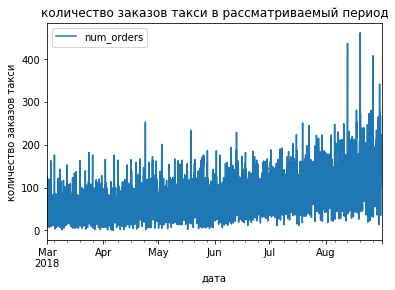

In [15]:
df.plot()
plt.title('количество заказов такси в рассматриваемый период')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.show()

По этому графику сложно делать выводы. Видно что количество заказов в течение времени не равномерно, к концу рассматриваемого периода предположительно увеличилось количество заказов. Чтобы данные были более нагляды проведём сглаживание.

Для сглаживания графика применим метод скльзящего среднего с интвервалом 24 (одни сутки)

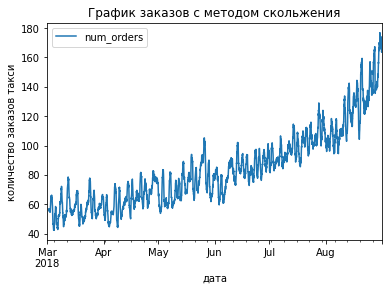

In [16]:
df.rolling(24, closed='left').mean().plot();
plt.title('График заказов с методом скольжения')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.show()

Разбиене на тренд сезонность и остаток

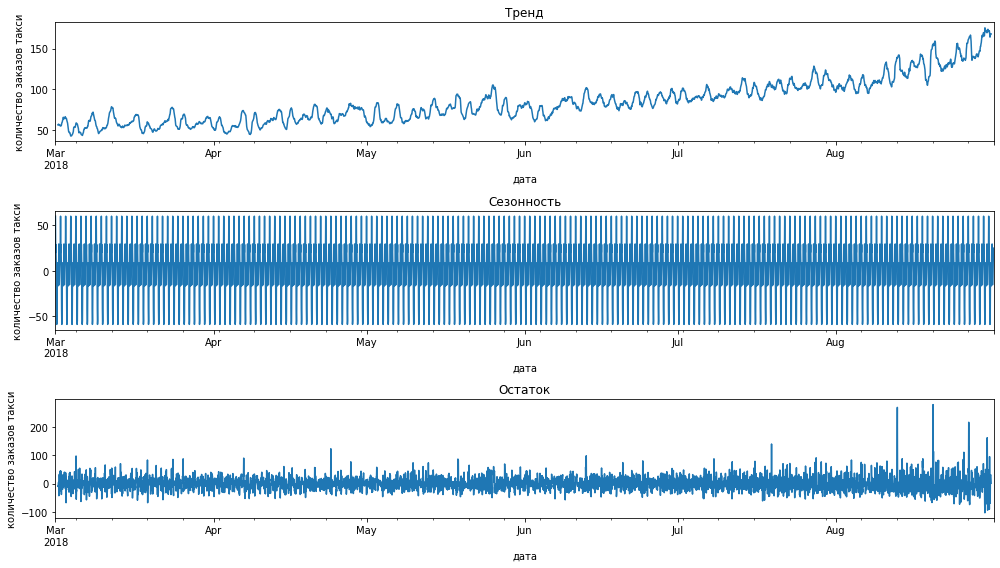

In [17]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(14, 8))
plt.subplot(311)


# тренд 
decomposed.trend.plot(ax=plt.gca())
plt.title("Тренд")
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.subplot(312)

# сезонность
decomposed.seasonal.plot(ax=plt.gca())
plt.title("Сезонность")
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.subplot(313)

# остаток
decomposed.resid.plot(ax=plt.gca())
plt.title("Остаток")
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.tight_layout()




Наблюдается тренд на повышение количества заказов, также наблюдается "сезонность". Возможно количество заказов зависит от дня недели.

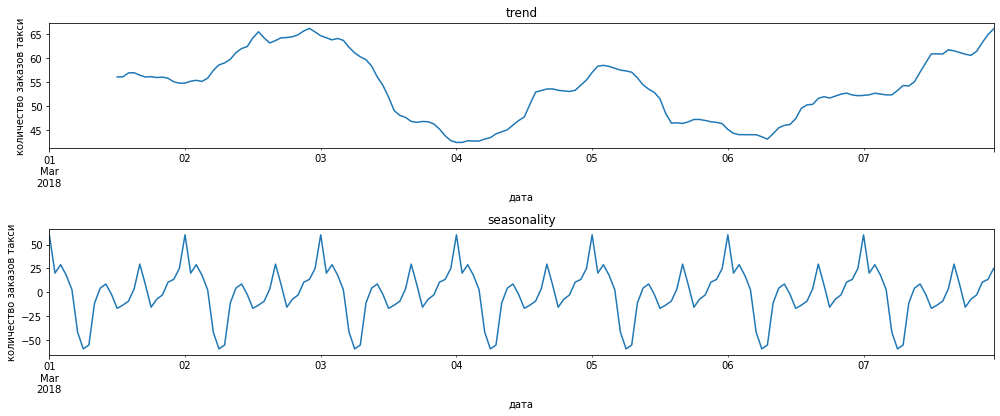

In [18]:
plt.figure(figsize=(14, 8))
plt.subplot(311)

decomposed.trend['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('trend')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.subplot(312)


decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('seasonality')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.tight_layout()



In [19]:
# определим какрй день недели приходится на дату
day_of_week = pd.Series(pd.date_range (start='1/3/2018', freq='D', periods= 7))
day_of_week.dt.day_name()

0    Wednesday
1     Thursday
2       Friday
3     Saturday
4       Sunday
5       Monday
6      Tuesday
dtype: object

Похоже, что пик приходится на пятницу, минимальное количество заказов по субботам и понедельникам

Проверим сезоннсть на меньшем интервале,в 2е суток

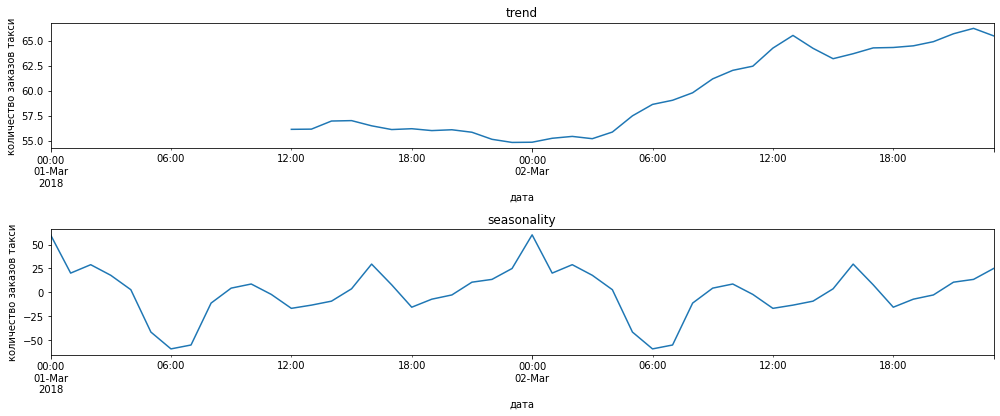

In [20]:
plt.figure(figsize=(14, 8))
plt.subplot(311)

decomposed.trend['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('trend')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.subplot(312)


decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('seasonality')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.tight_layout()



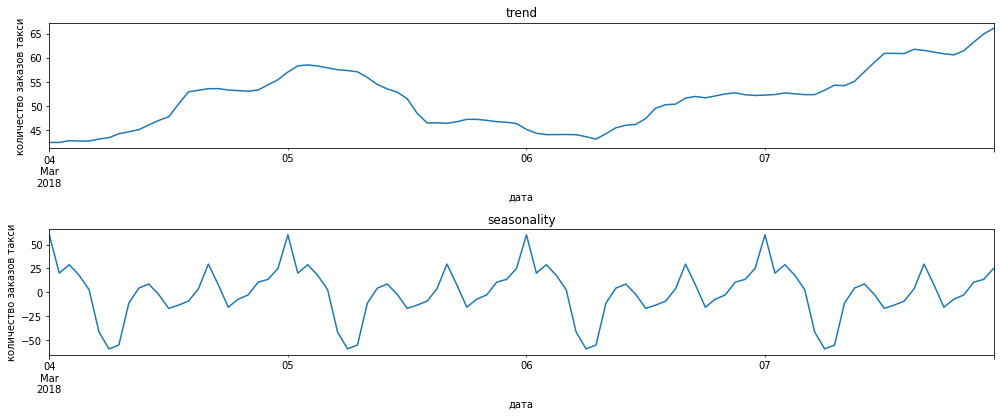

In [21]:
plt.figure(figsize=(14, 8))
plt.subplot(311)

decomposed.trend['2018-03-04':'2018-03-07'].plot(ax=plt.gca())
plt.title('trend')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.subplot(312)


decomposed.seasonal['2018-03-04':'2018-03-07'].plot(ax=plt.gca())
plt.title('seasonality')
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.tight_layout()



Заметно, что есть сезоннсть в течение суток. Пик приходтся на 00:00 часов ночи, минимум на 6:00 часов утра.
Вероятно это связано с работой общественного транспорта, К ночи общественный транспорт ходит реже, а к утру, возможно меньше рейсов.

**Страционарный ли ряд?**

Стандартное отклонение

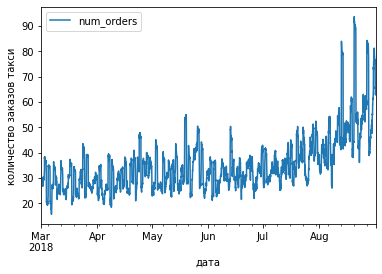

In [22]:
df.rolling(24, closed='left').std().plot()
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.show()

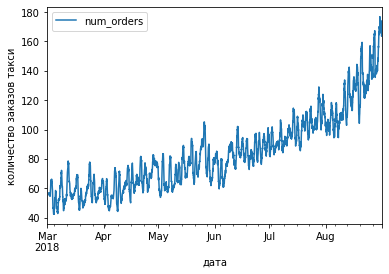

In [23]:
df.rolling(24, closed='left').mean().plot();
plt.xlabel('дата')
plt.ylabel('количество заказов такси')
plt.show()

Ряд нестационарен, т.к. среднее повышается. Нестационарные ряды сложно прогнозировать. В процессе придётся использовать смещение, чтобы сделать ряд более стационарным.

Проверим также стационарость ряда с помощью метода Дики — Фуллера. Для этого используем функцию adfuller из библиотеки statsmodels. 

Нулевая гипотеза - ряд нестационарен. 

Альтерантивная гипотеза - ряд стационарен. Уровень значимости применим 1% и 5%.

In [24]:
# используем функцию adfuller для проверки стационарности ряда
result = adfuller(df)

# ввыводи информацию на экран
print("p-value: %.3f" % result[1])
print("уровни значимости:")
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


p-value: 0.029
уровни значимости:
	1%: -3.432
	5%: -2.862
	10%: -2.567


P-value меньше уровней значимости 5%, но выше 1% а значит мы не может однозначно отбросить нулевую гипотезу и считать ряд стационарным. Учитываю, что на прдыдущих график есть явное наличие тренда, всё же оставим нулевую гипотезу и считаем ряд нестационарным.

Сгладили график, для этого использовали метод скользящего среднего. Выяснили, что согласно данным есть тренд на повышение и сезонность в течение недели. Выяснили, что ряд не стационарен и перед обучением модели нужно будет использовать смещение.

## Обучение

Нам нужно спрогнозировать количество заказов такси - это задача регресси.

Создадим признаки

In [25]:
def make_features(df, max_lag, rolling_mean_size):
    df_foo = df.copy()
# получаем признаки времени    
    df_foo['day'] = df_foo.index.day
    df_foo['dayofweek'] = df_foo.index.dayofweek
    df_foo['hour'] = df_foo.index.hour
    
# получаем отстающие значения для предсказания будут ли значения увеличиваться или уменьшаться    
    for lag in range(1, max_lag+1):
        df_foo['lag_{}'.format(lag)] = df_foo['num_orders'].shift(lag)

# скользящее среднее как признак задаёт общий тренд временного ряда
    df_foo['rolling_mean'] = df_foo['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    
    return df_foo

In [26]:
df = make_features(df, 24, 48)
df.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
#разделяем датасет на тренировочную и тестовую выборки
train, valid = train_test_split(df, shuffle=False, test_size=0.3)
valid, test = train_test_split(valid, shuffle=False, test_size=0.33)
train = train.dropna()

In [28]:
# выделяем обучающие и целевой признаки
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_valid = valid.drop('num_orders', axis=1)
y_valid = valid['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [29]:
# обучаем модель
model = LinearRegression()
model.fit(X_train, y_train)

# получаем прогноз
predictions_valid = model.predict(X_valid)

# получаем метрику
RMSE_linear = mean_squared_error(y_valid, predictions_valid)**0.5
print('RMSE valid:', RMSE_linear)

RMSE valid: 32.69889397933925


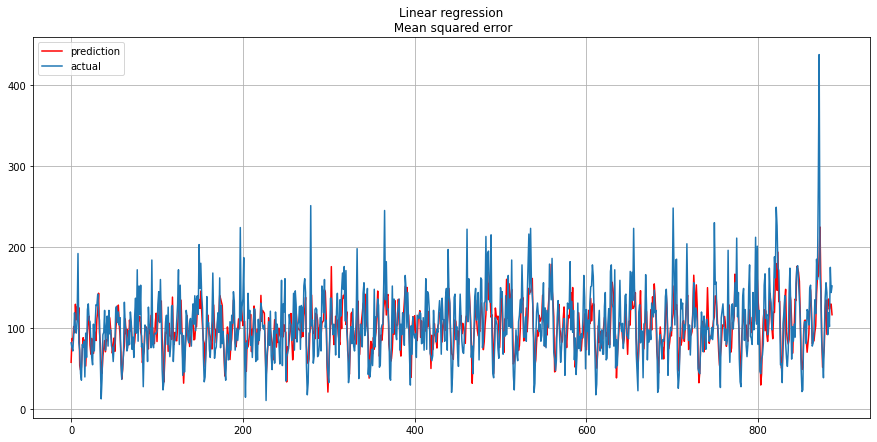

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(predictions_valid, "r", label="prediction")
plt.plot(y_valid.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean squared error")
plt.grid(True);

Так же обучим ещё одну модель, например случайный лес. Подберём для неё опитмальны параметры в цикле.

In [31]:
best_model = None
best_result = 120
best_est = None
best_depth = 0
best_predictions_valid = None
for est in range(1, 41, 5):
    for depth in range(1, 6):
        model_forest = RandomForestRegressor(random_state=42, n_estimators=est, max_depth = depth) # обучение модели с заданным числом деревьев
        model_forest.fit(X_train, y_train) # обучение модели на тренировочной выборке
        predictions_valid_forest = model_forest.predict(X_valid)
        result = mean_squared_error(y_valid, predictions_valid_forest)**0.5 # подсчёт качества модели на валидационной выборке
        if result < best_result:
            best_result = result # сохранение наилучшего значений метрики accurcy на валидационных данных
            best_est = est
            best_depth = depth
            best_predictions_valid = predictions_valid_forest
print("RMSE наилучшей модели на валидационной выборке:", best_result, "с количеством деревьев:", best_est,
     "и глубиной деревьев:", best_depth)
    

RMSE наилучшей модели на валидационной выборке: 34.74029003805012 с количеством деревьев: 6 и глубиной деревьев: 5


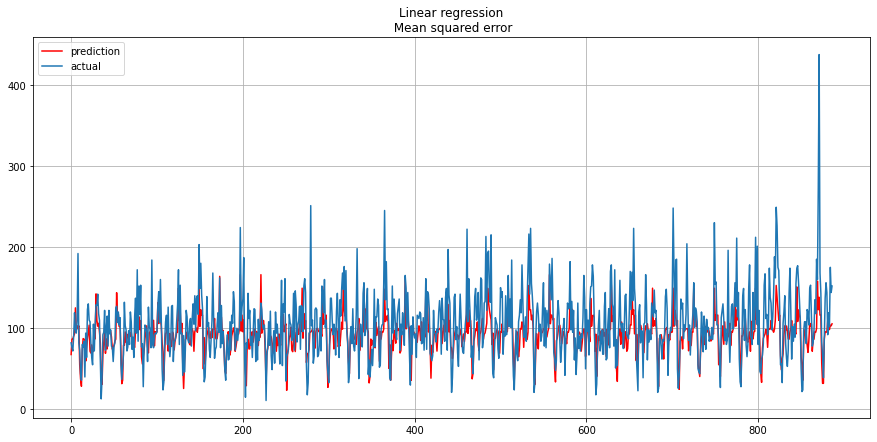

In [32]:
plt.figure(figsize=(15, 7))
plt.plot(best_predictions_valid, "r", label="prediction")
plt.plot(y_valid.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean squared error")
plt.grid(True);

С визуализаций предсказаний заметно, что случайный лес немного хуже предсказывает пики, чем обычная линейная модель. У линейной модели также немного лучше показатель метрики.

**Вывод:**


Выделили как целевые признаки: дни, дни недели и часы дня. Подготовили данные использую отстающие значения и скользящее среднее.  Разделили данные на тренировочную, валидну и тестовую выборки. Тестовая выборка размере около 10% от полного датасета. Обучили модели линеной регрессии и случайный лес регрессии. На обеих моделях получили значения RMSE  меньше 48. 
Далее проведём тестирование моделей на тестовой выборке

## Тестирование

Проведём тестирование линейной модели на тестовой выборке

In [33]:
# проверка на тестовой выборке линейной модели, уже обучена
predictions_test_linear = model.predict(X_test)

final_result = mean_squared_error(y_test, predictions_test_linear)**0.5

print('RMSE linear test:', final_result)

RMSE linear test: 46.583405822319435


Значение RMSE вполне устраиват. По условию оно должно быть ниже 48. У обычной линейной модели точность выше.

Визаулизируем графики предсказания модели и тестовых данных.

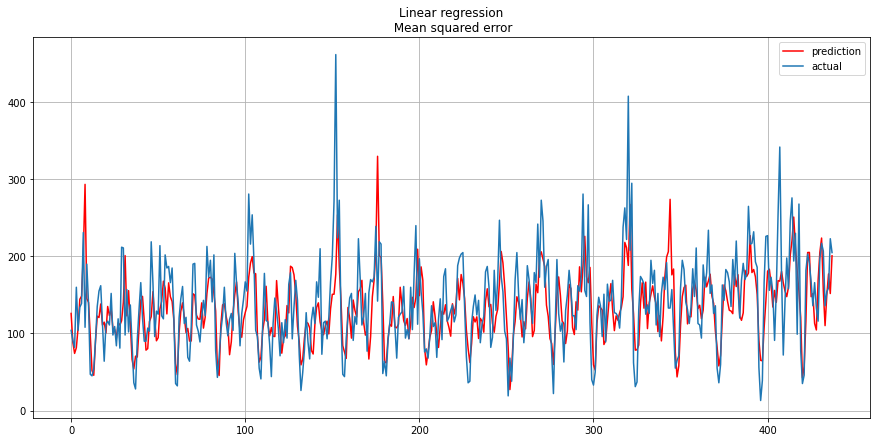

In [34]:
plt.figure(figsize=(15, 7))
plt.plot(predictions_test_linear, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean squared error")
plt.grid(True);

Не тестовых данных пики предсказываются, но хуже чем на валидных.

Проверим модели на вменяемость c помощью DummyRegressor

In [35]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_model = dummy_regr.fit(X_train, y_train)
dummy_predict = dummy_model.predict(X_test)
dummy_result = mean_squared_error(y_test, dummy_predict)**0.5

print('RMSE DummyRegressor:', dummy_result)
print('RMSE линейной модели', final_result)

RMSE DummyRegressor: 90.41544558924352
RMSE линейной модели 46.583405822319435


Значение RMSE DummyRegressor в три раза хуже показателей модели и почтиа в два раза выше целевого показателя в 48, что значит что линейная модель лучше справляется с предсказаниями

**Итоговый вывод**

Подготовили данные. Удалили выбросы. Проанализировали данные. Выяснили, что в данных существует тренд на повышение и сезонность в течение недели с пиком на пятницу и минимальным количеством заказов в субботу и понедельник. Обучили модели и смогли достаточно точно предсказать количество заказов такси в тестовой выборке. Сравнивали модели LinearRegressian и RandomForestRegression на валидной выборке. Линейная модель предсказывает лучше. Протестироваили линейную модель на тестовой выборке и сравнили её с константной моделью. Предсказанию константной модели значително хуже. Можно рекоммендовать линейную модель для использования прогноза заказа такси.